# Web Scraping Linkedin Job Page with Selenium Python and Performing Quantitative Text Analysis on the Job Description Data

Links used: https://medium.com/@kurumert/web-scraping-linkedin-job-page-with-selenium-python-e0b6183a5954
N.B - For this project, I adapted the code built developed by Mert Kucukkuru to scrape job posts from Linkedin. As the code is slightly outdated, I had to re-write some of the code to make it compatible with the updated Selenium library. I then performed QTA on the job_description data to gain insights on which skills are the most sought after in Data Science jobs. I highly recommend the link (see above) for a very helpful guide on how to scrape job posts from Linkedin before carrying out data analysis.

In [52]:
# Import libraries

import time
import pandas as pd
import os
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud



In [2]:
#Check directory

os.getcwd() 


'C:\\Users\\kerme'

In [3]:
# Driver's path
path = '/Users/kerme/Downloads/chromedriver.exe'
driver = webdriver.Chrome(path)

<ipython-input-3-aba8c2f79642>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(path)


In [4]:
# Maximize Window
driver.maximize_window() 
driver.minimize_window() 
driver.maximize_window() 
driver.switch_to.window(driver.current_window_handle)
driver.implicitly_wait(10)

In [5]:
# Enter to the site
driver.get("https://www.linkedin.com/login");
time.sleep(2)

In [6]:
# Accept cookies from Linkedin

driver.find_element("xpath", '//*[@id="artdeco-global-alert-container"]/div/section/div/div[2]/button[1]').click()

In [7]:
# User Credentials
# Reading txt file where we have our user credentials

with open('user_credentials.txt', 'r',encoding="utf-8") as file:
    user_credentials = file.readlines()
    user_credentials = [line.rstrip() for line in user_credentials]
user_name = user_credentials[0] # First line
password = user_credentials[1] # Second line


In [8]:
driver.find_element("xpath", '//*[@id="username"]').send_keys(user_name)
driver.find_element("xpath", '//*[@id="password"]').send_keys(password)
time.sleep(1)


In [9]:
# Login button
driver.find_element("xpath", '//*[@id="organic-div"]/form/div[3]/button').click()
driver.implicitly_wait(30)


In [10]:

# Access to the Jobs button and click it
driver.find_element("xpath", '//*[@id="global-nav"]/div/nav/ul/li[3]/a').click()
time.sleep(3)


In [11]:
# Go to search results directly via link
driver.get("https://www.linkedin.com/jobs/search/?currentJobId=3429038879&f_TPR=r2592000&geoId=103350119&keywords=data%20scientist&location=Italy&refresh=true")
time.sleep(1)


In [12]:
# Get all links for these offers
links = []

In [13]:
# Navigate 13 pages
print('Links are being collected now.')

try: 
    for page in range(2,10):
        time.sleep(2)
        jobs_block = driver.find_element(By.CLASS_NAME, 'jobs-search-results-list')
        jobs_list = jobs_block.find_elements(By.CSS_SELECTOR, '.jobs-search-results__list-item')
        
        for job in jobs_list:
            all_links = job.find_elements(By.CSS_SELECTOR, 'a')
            
            for a in all_links:
                if str(a.get_attribute('href')).startswith("https://www.linkedin.com/jobs/view") and a.get_attribute('href') not in links: 
                    links.append(a.get_attribute('href'))
                else:
                    pass
                
            # scroll down for each job element
            driver.execute_script("arguments[0].scrollIntoView();", job)
        
        print(f'Collecting the links in the page: {page-1}')
        # go to next page:
        driver.find_element(By.XPATH, f"//button[@aria-label='Page {page}']").click()
        time.sleep(3)
        
except:
    pass
print('Found ' + str(len(links)) + ' links for job offers') 

Links are being collected now.
Found 168 links for job offers


In [14]:
# Create empty lists to store information
job_titles = []
company_names = []
company_locations = []
work_methods = []
post_dates = []
work_times = [] 
job_desc = []

i = 0
j = 1

# Visit each link one by one to scrape the information
print('Visiting the links and collecting information just started.')
for i in range(len(links)):
    try:
        driver.get(links[i])
        i=i+1
        time.sleep(2)
        # Click See more.
        driver.find_element(By.CLASS_NAME, "artdeco-card__actions").click()
        time.sleep(2)
    except:
        pass
    
    # Find the general information of the job offer
    # Used try, except in case there is some missing information for some of the job offers
    contents = driver.find_elements(By.CLASS_NAME,'p5')
    for content in contents:
        try:
            job_titles.append(content.find_element("tag name", "h1").text)
            company_names.append(content.find_element(By.CLASS_NAME, "jobs-unified-top-card__company-name").text)
            company_locations.append(content.find_element(By.CLASS_NAME, "jobs-unified-top-card__bullet").text)
            work_methods.append(content.find_element(By.CLASS_NAME, "jobs-unified-top-card__workplace-type").text)
            post_dates.append(content.find_element(By.CLASS_NAME, "jobs-unified-top-card__posted-date").text)
            work_times.append(content.find_element(By.CLASS_NAME, "jobs-unified-top-card__job-insight").text)
            print(f'Scraping the Job Offer {j} DONE.')
            j+= 1
            
        except:
            pass
        time.sleep(2)
        
        # Scraping the job description
    job_description = driver.find_elements(By.CLASS_NAME, 'jobs-description__content')
    for description in job_description:
        job_text = description.find_element(By.CLASS_NAME, "jobs-box__html-content").text
        job_desc.append(job_text)
        print(f'Scraping the Job Offer {j}')
        time.sleep(2)  

Visiting the links and collecting information just started.
Scraping the Job Offer 1 DONE.
Scraping the Job Offer 2
Scraping the Job Offer 2 DONE.
Scraping the Job Offer 3
Scraping the Job Offer 3 DONE.
Scraping the Job Offer 4
Scraping the Job Offer 4 DONE.
Scraping the Job Offer 5
Scraping the Job Offer 5 DONE.
Scraping the Job Offer 6
Scraping the Job Offer 6 DONE.
Scraping the Job Offer 7
Scraping the Job Offer 7 DONE.
Scraping the Job Offer 8
Scraping the Job Offer 8 DONE.
Scraping the Job Offer 9
Scraping the Job Offer 9 DONE.
Scraping the Job Offer 10
Scraping the Job Offer 10 DONE.
Scraping the Job Offer 11
Scraping the Job Offer 11 DONE.
Scraping the Job Offer 12
Scraping the Job Offer 12 DONE.
Scraping the Job Offer 13
Scraping the Job Offer 13 DONE.
Scraping the Job Offer 14
Scraping the Job Offer 14 DONE.
Scraping the Job Offer 15
Scraping the Job Offer 15 DONE.
Scraping the Job Offer 16
Scraping the Job Offer 16 DONE.
Scraping the Job Offer 17
Scraping the Job Offer 17 DON

Scraping the Job Offer 140
Scraping the Job Offer 140 DONE.
Scraping the Job Offer 141
Scraping the Job Offer 141 DONE.
Scraping the Job Offer 142
Scraping the Job Offer 142 DONE.
Scraping the Job Offer 143
Scraping the Job Offer 143 DONE.
Scraping the Job Offer 144
Scraping the Job Offer 144 DONE.
Scraping the Job Offer 145
Scraping the Job Offer 145 DONE.
Scraping the Job Offer 146
Scraping the Job Offer 146 DONE.
Scraping the Job Offer 147
Scraping the Job Offer 147 DONE.
Scraping the Job Offer 148
Scraping the Job Offer 148 DONE.
Scraping the Job Offer 149
Scraping the Job Offer 149 DONE.
Scraping the Job Offer 150
Scraping the Job Offer 150
Scraping the Job Offer 150 DONE.
Scraping the Job Offer 151
Scraping the Job Offer 151 DONE.
Scraping the Job Offer 152
Scraping the Job Offer 152 DONE.
Scraping the Job Offer 153
Scraping the Job Offer 153 DONE.
Scraping the Job Offer 154
Scraping the Job Offer 154 DONE.
Scraping the Job Offer 155
Scraping the Job Offer 155 DONE.
Scraping the 

In [15]:
# Creating the dataframe 
df = pd.DataFrame(list(zip(job_titles,company_names,
                    company_locations,work_methods,
                    post_dates,work_times)),
                    columns =['job_title', 'company_name',
                           'company_location','work_method',
                           'post_date','work_time'])

# Storing the data to csv file
df.to_csv('job_offers.csv', index=False)

In [16]:
df

,job_title,company_name,company_location,work_method,post_date,work_time
0,Senior Data Scientist,Logispin Group,"Lecce, Apulia, Italy",Hybrid,2 weeks ago,Full-time · Associate
1,Senior Data Scientist,BID Company,"Milan, Lombardy, Italy",Hybrid,2 weeks ago,Full-time · Mid-Senior level
2,Data Scientist,Telepass,"Rome, Latium, Italy",Hybrid,2 weeks ago,Full-time · Mid-Senior level
3,Data Scientist,Gruppo MOL,"Milan, Lombardy, Italy",Hybrid,2 weeks ago,Full-time · Mid-Senior level
4,Data Scientist,XTN Cognitive Security®,"Padua, Veneto, Italy",Hybrid,1 day ago,Full-time
...,...,...,...,...,...,...
160,Project Manager,Ingenium,"Rome, Latium, Italy",On-site,20 hours ago,Full-time · Entry level
161,Business Data Analyst,TIM,"Rome, Latium, Italy",On-site,20 hours ago,Full-time · Internship
162,Firmwarista Junior,Pellini,"Codogno, Lombardy, Italy",On-site,19 hours ago,Full-time · Entry level
163,DATA PRODUCT SPECIALIST,Quadra Research Srl - Executive Search,"Veneto, Italy",Remote,2 hours ago,Contract


In [31]:
# Output job descriptions to txt file
with open('job_descriptions.txt', 'w',encoding="utf-8") as f:
    for line in job_desc:
        f.write(line)
        f.write('\n')

In [32]:
# Load the text file into a Pandas DataFrame:

with open('job_descriptions.txt', 'r', encoding = 'utf-8') as file:
    data = file.readlines()
    
df2 = pd.DataFrame({'description': data})



In [33]:
# remove stopwords
stop_words = set(stopwords.words("english")) | set(stopwords.words("italian"))
df2['description'] = df2['description'].str.lower()
df2['tokens'] = df2['description'].apply(word_tokenize)
df2['tokens'] = df2['tokens'].apply(lambda x: [word for word in x if word.isalpha() and word not in stop_words])


In [35]:
# Generate a frequency distribution of the tokens:
fdist = FreqDist([word for tokens in df2['tokens'] for word in tokens])

In [36]:
fdist

FreqDist({'data': 875, 'team': 320, 'business': 282, 'conoscenza': 256, 'experience': 223, 'learning': 220, 'job': 209, 'dati': 174, 'work': 172, 'science': 164, ...})

<AxesSubplot:>

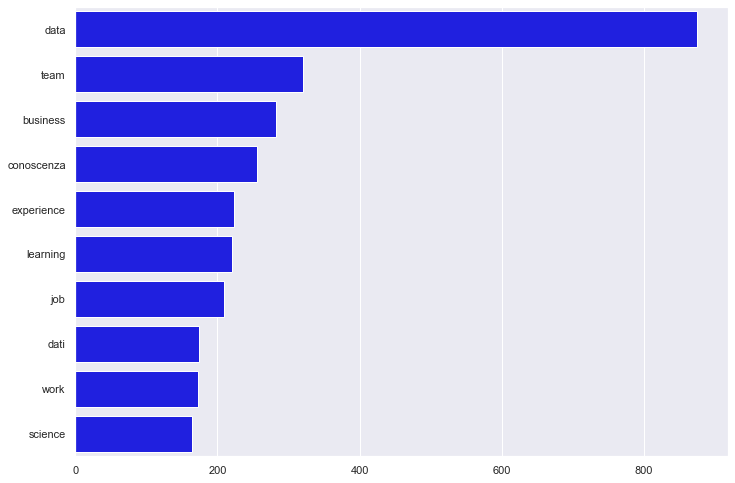

In [39]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Sort frequency distribution in descending order
fdist_sorted = dict(sorted(fdist.items(), key=lambda x: x[1], reverse=True))

# Plot bar plot
sns.barplot(x=list(fdist_sorted.values())[:10], y=list(fdist_sorted.keys())[:10], color='blue')


<AxesSubplot:>

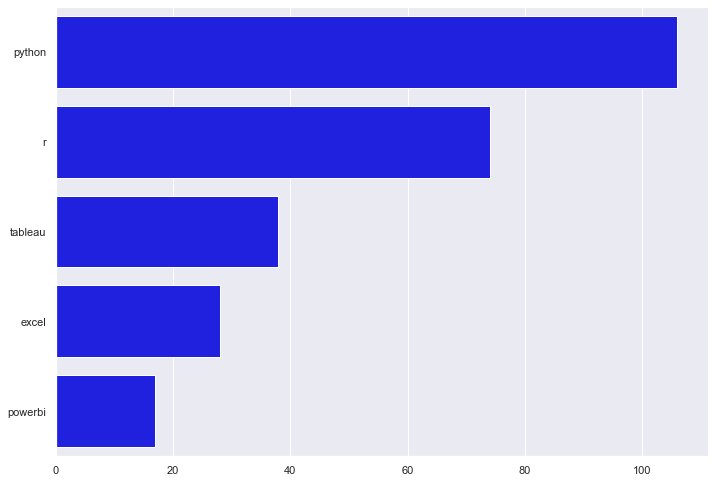

In [48]:
# Create a filtered bar chart to compare the keyword count of popular programs used by data scientists
# Set default figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})

# Keywords of interest
keywords = ['tableau', 'r', 'python', 'excel', 'SQL', 'powerbi']

# Extract only the keywords of interest from frequency distribution
fdist_filtered = {k: v for k, v in fdist.items() if k in keywords}

# Sort filtered frequency distribution in descending order
fdist_sorted = dict(sorted(fdist_filtered.items(), key=lambda x: x[1], reverse=True))

# Plot bar plot
sns.barplot(x=list(fdist_sorted.values()), y=list(fdist_sorted.keys()), color='blue')


In [50]:
#Perform topic modeling using Latent Dirichlet Allocation (LDA):

vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
X = vectorizer.fit_transform(df2['tokens'].tolist())

lda = LatentDirichletAllocation(n_components=10, random_state=0)
topics = lda.fit_transform(X)


In [51]:
# Print the 10 most common topics:

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])

print_topics(lda, vectorizer)


Topic 0:
['conoscenza', 'learning', 'knowledge', 'python', 'sql', 'machine', 'data', 'r', 'plus', 'skills']
Topic 1:
['esperienza', 'capacità', 'anni', 'lavorare', 'requisiti', 'attività', 'sviluppo', 'team', 'ruolo', 'ambito']
Topic 2:
['sede', 'milano', 'lavoro', 'roma', 'english', 'colloquio', 'location', 'time', 'language', 'written']
Topic 3:
['business', 'competenze', 'team', 'capacità', 'opportunità', 'tempo', 'formazione', 'lavoro', 'data', 'learning']
Topic 4:
['data', 'job', 'team', 'scientist', 'business', 'analysis', 'projects', 'join', 'science', 'analytics']
Topic 5:
['dati', 'data', 'analisi', 'modelli', 'business', 'ricerca', 'soluzioni', 'sviluppo', 'cliente', 'supporto']
Topic 6:
['requirements', 'persone', 'clienti', 'business', 'integration', 'search', 'proprio', 'troverai', 'attraverso', 'lavoro']
Topic 7:
['experience', 'laurea', 'ingegneria', 'working', 'data', 'analytics', 'relazionali', 'informatica', 'work', 'role']
Topic 8:
['experience', 'degree', 'employmen

Topic 0:
['conoscenza', 'learning', 'knowledge', 'python', 'sql', 'machine', 'data', 'r', 'plus', 'skills']


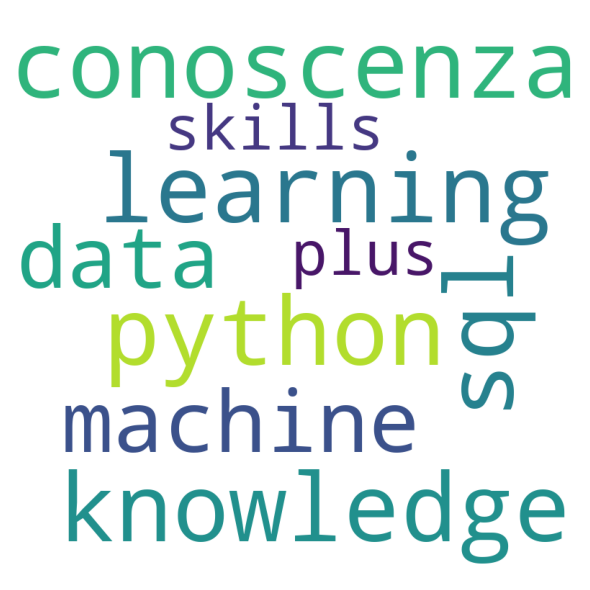

Topic 1:
['esperienza', 'capacità', 'anni', 'lavorare', 'requisiti', 'attività', 'sviluppo', 'team', 'ruolo', 'ambito']


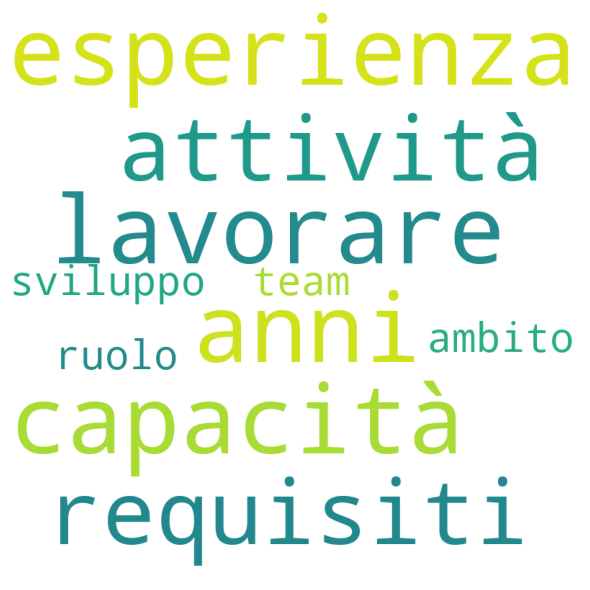

Topic 2:
['sede', 'milano', 'lavoro', 'roma', 'english', 'colloquio', 'location', 'time', 'language', 'written']


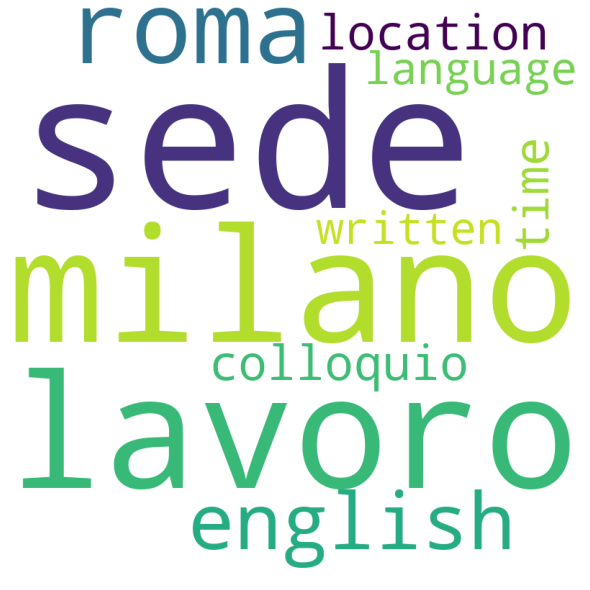

Topic 3:
['business', 'competenze', 'team', 'capacità', 'opportunità', 'tempo', 'formazione', 'lavoro', 'data', 'learning']


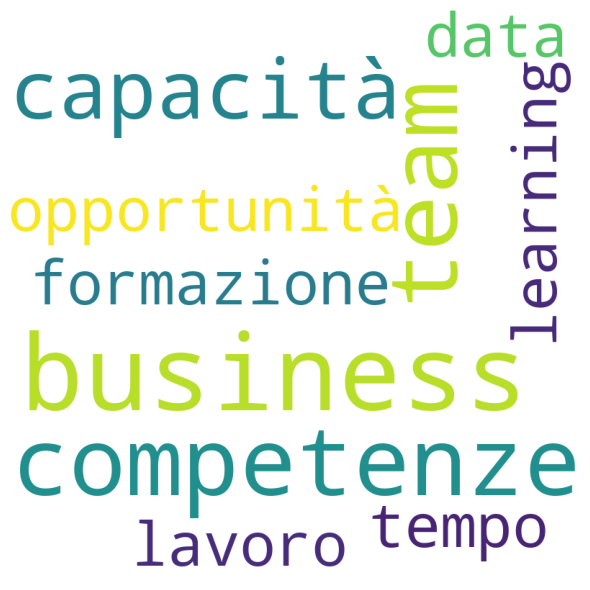

Topic 4:
['data', 'job', 'team', 'scientist', 'business', 'analysis', 'projects', 'join', 'science', 'analytics']


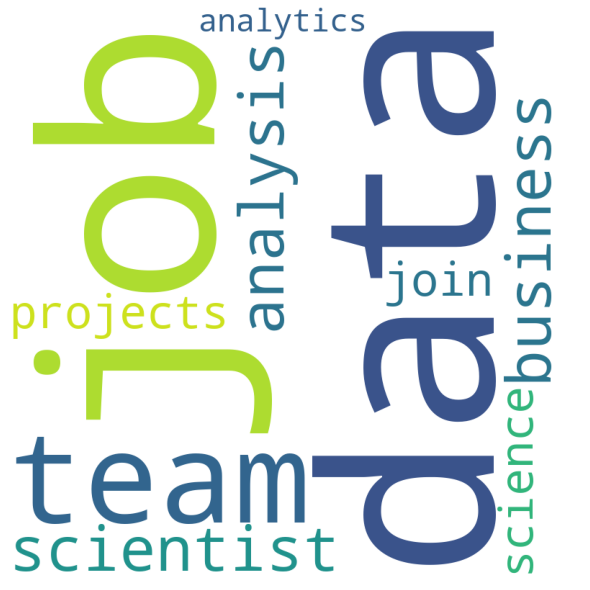

Topic 5:
['dati', 'data', 'analisi', 'modelli', 'business', 'ricerca', 'soluzioni', 'sviluppo', 'cliente', 'supporto']


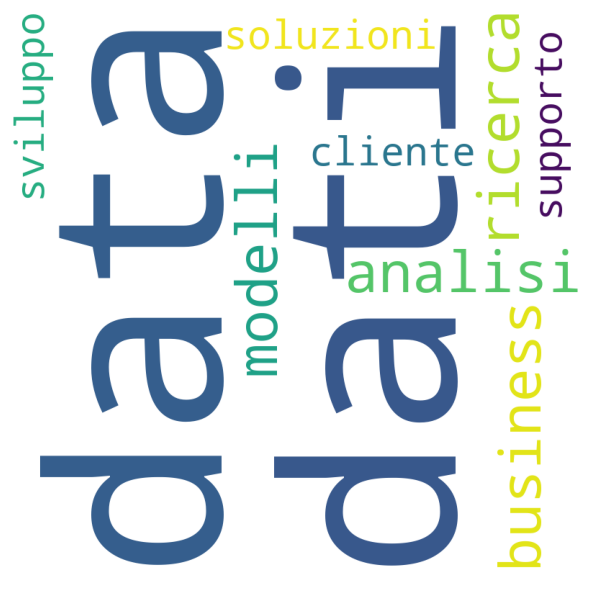

Topic 6:
['requirements', 'persone', 'clienti', 'business', 'integration', 'search', 'proprio', 'troverai', 'attraverso', 'lavoro']


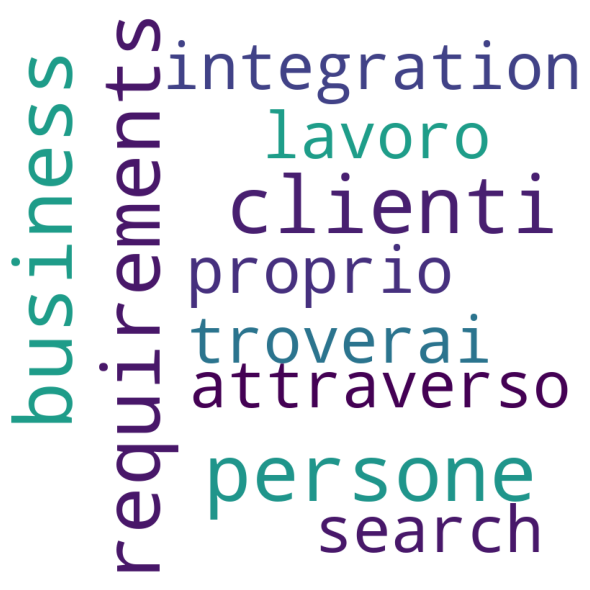

Topic 7:
['experience', 'laurea', 'ingegneria', 'working', 'data', 'analytics', 'relazionali', 'informatica', 'work', 'role']


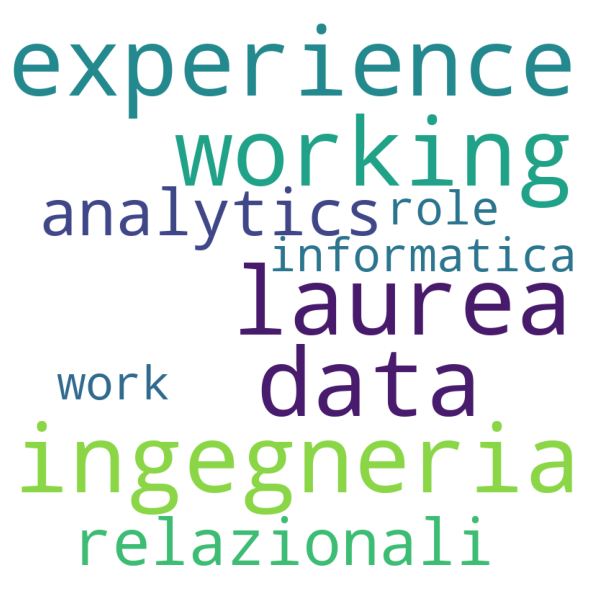

Topic 8:
['experience', 'degree', 'employment', 'status', 'work', 'equal', 'statistics', 'mathematics', 'science', 'gsk']


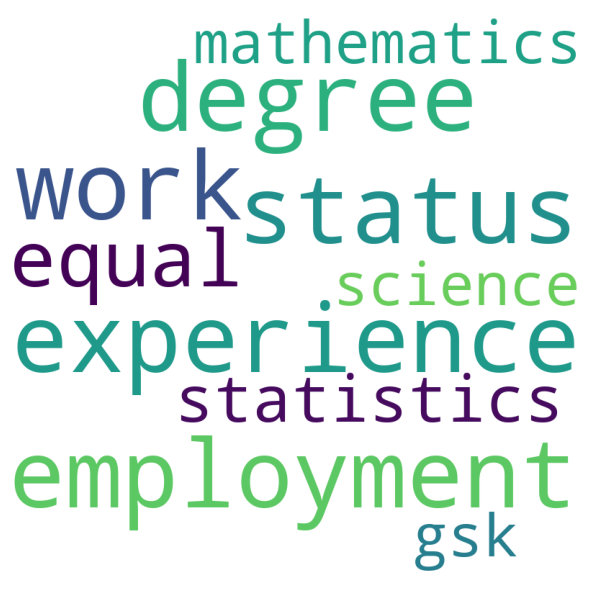

Topic 9:
['digital', 'transformation', 'company', 'marketing', 'oltre', 'cosa', 'team', 'work', 'consulting', 'technology']


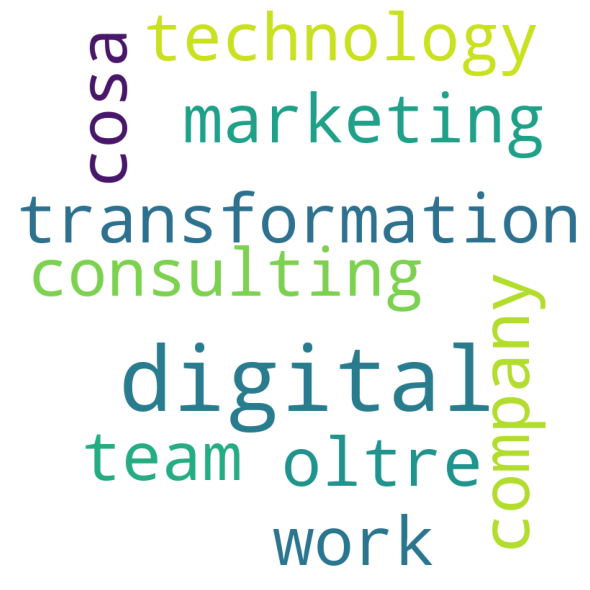

In [53]:
# Create a word cloud of the top keywords for each topic:

def plot_wordcloud(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        words = [vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]]
        print(words)
        wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=None, min_font_size=10).generate(" ".join(words))
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.show()

plot_wordcloud(lda, vectorizer)


Topic 0:
['conoscenza', 'learning', 'knowledge', 'python', 'sql', 'machine', 'data', 'r', 'plus', 'skills']


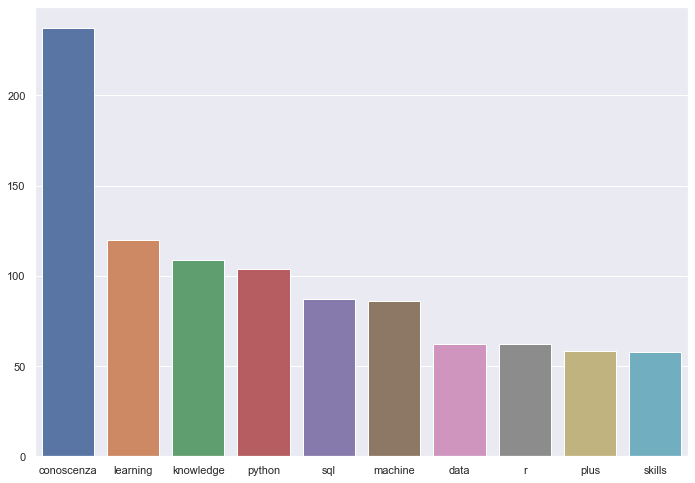

Topic 1:
['esperienza', 'capacità', 'anni', 'lavorare', 'requisiti', 'attività', 'sviluppo', 'team', 'ruolo', 'ambito']


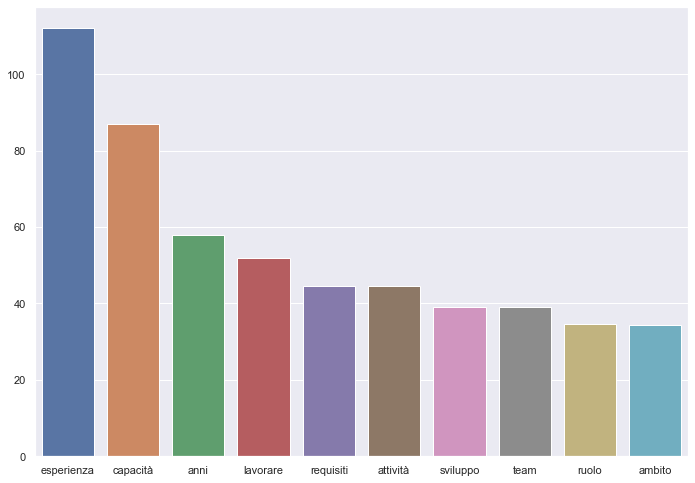

Topic 2:
['sede', 'milano', 'lavoro', 'roma', 'english', 'colloquio', 'location', 'time', 'language', 'written']


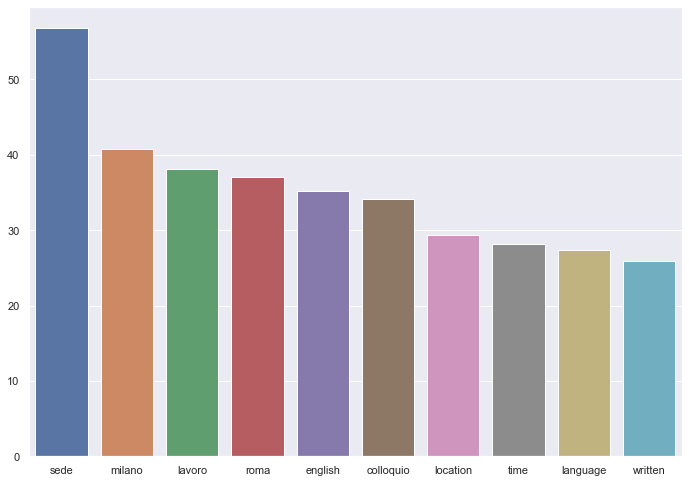

Topic 3:
['business', 'competenze', 'team', 'capacità', 'opportunità', 'tempo', 'formazione', 'lavoro', 'data', 'learning']


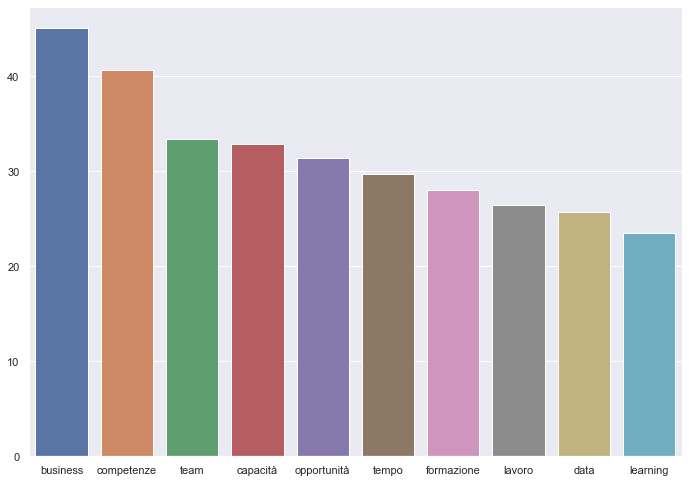

Topic 4:
['data', 'job', 'team', 'scientist', 'business', 'analysis', 'projects', 'join', 'science', 'analytics']


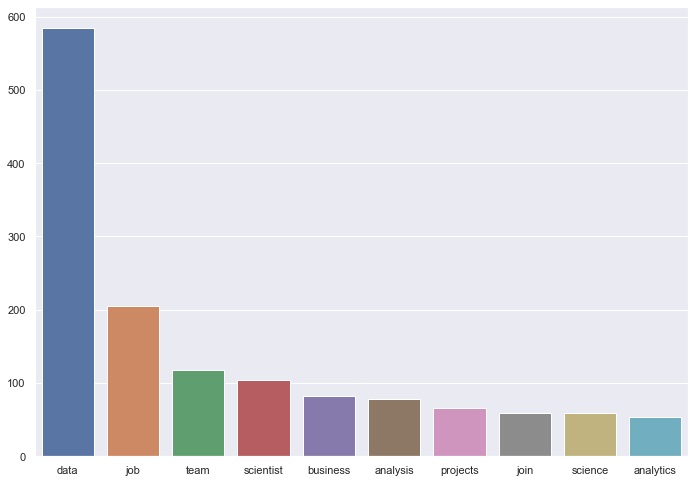

Topic 5:
['dati', 'data', 'analisi', 'modelli', 'business', 'ricerca', 'soluzioni', 'sviluppo', 'cliente', 'supporto']


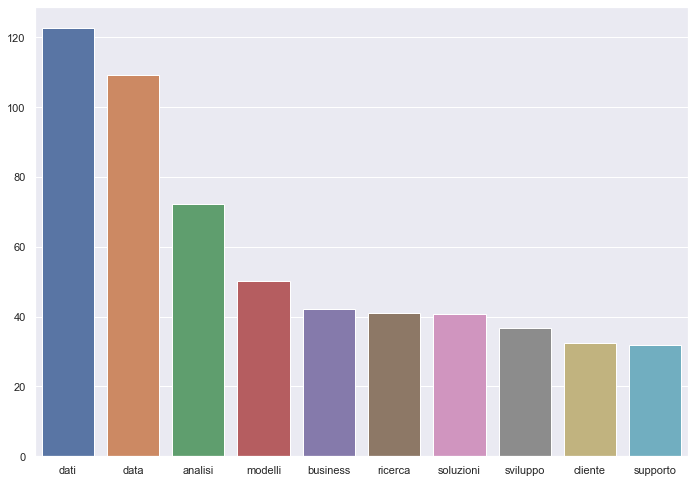

Topic 6:
['requirements', 'persone', 'clienti', 'business', 'integration', 'search', 'proprio', 'troverai', 'attraverso', 'lavoro']


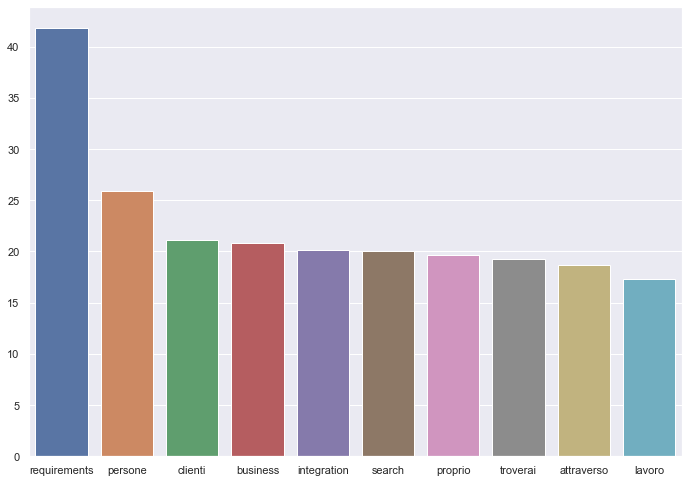

Topic 7:
['experience', 'laurea', 'ingegneria', 'working', 'data', 'analytics', 'relazionali', 'informatica', 'work', 'role']


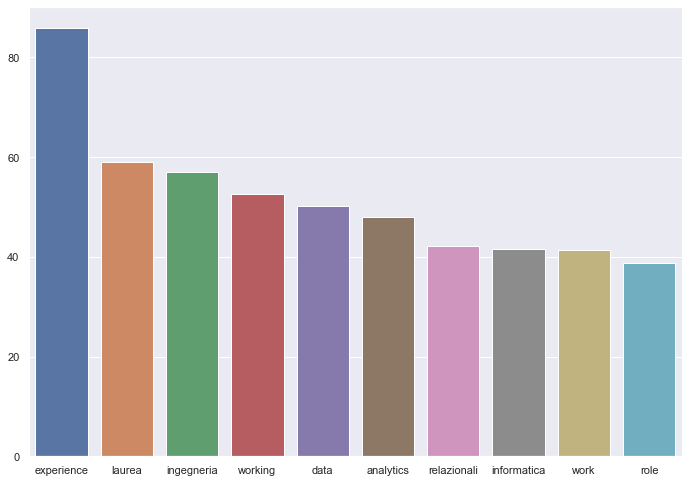

Topic 8:
['experience', 'degree', 'employment', 'status', 'work', 'equal', 'statistics', 'mathematics', 'science', 'gsk']


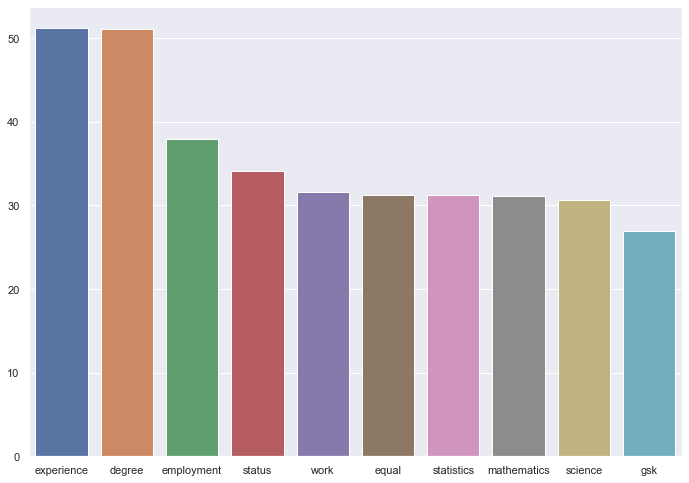

Topic 9:
['digital', 'transformation', 'company', 'marketing', 'oltre', 'cosa', 'team', 'work', 'consulting', 'technology']


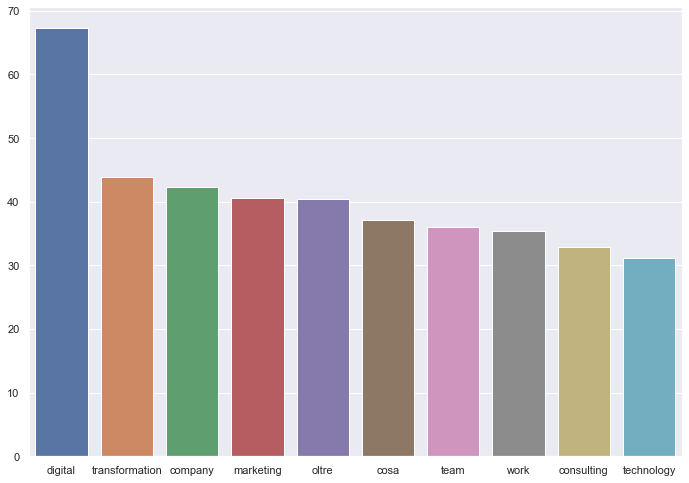

In [54]:
# create a bar plot of the top keywords for each topic using Seaborn:

def plot_bargrid(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        words = [vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]]
        print(words)
        values = topic[topic.argsort()[:-top_n - 1:-1]]
        sns.barplot(x=words, y=values)
        plt.show()

plot_bargrid(lda, vectorizer)
